# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

## Imports

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [6]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /home/tensorflow/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1568805 sha256=2fb1bd74057a8250018ec848bc0914fcfdccef55df6216e924c3906444f5b5ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-7igg7jv8/wheels/05/6d/c9/a8417cc25d98db655a30a6ba4437b39ced9a4ea1ceb3083d60
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [4]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.3 MB 5.5 MB/s eta 0:00:01


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2 Physical GPUs, 2 Logical GPUs


# Have to execute from the follwing every time you restart 

In [16]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [3]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)


# gt_boxes set 

#### you should following the order ! y_left_up, x_left_up, y_right_bottom, x_right_bottom

```
gt_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]
```

In [12]:
# load_anotations
import pandas as pd
import cv2
import glob
import os
import numpy as np

df = pd.read_csv("/home/tensorflow/models/research/object_detection/test_images/cell_image/test.csv")
df.columns = ["nothing", "filenames", "x1", "x2", "y1", "y2", "classname"]

train_image_dir = "/home/tensorflow/models/research/object_detection/test_images/cell_image/anotated_image_v6_add_dataset/x/"
filenames = []
for root, dirs, files in os.walk(train_image_dir):
    for file in files:
        f = os.path.join(root, file)
        filenames.append(f)

gt_boxes = []
train_images_np = []

for f in filenames:
    target_df = df[df["filenames"] == f.split("/")[-1]]
    try:
        x1, = np.array(target_df["x1"]) 
        x2, = np.array(target_df["x2"]) 
        y1, = np.array(target_df["y1"]) 
        y2, = np.array(target_df["y2"]) 
        gt_boxes.append(np.float32([[y1, x1, y2 ,x2]]))
    except:
        pass
    
    img = cv2.imread(f)
    train_images_np.append(img)

In [7]:
len(gt_boxes)

20

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [13]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
character_class_id = 1
num_classes = 1

category_index = {1: {'id': 1, 'name': 'character'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))

    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)

    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

print("---------------------------------------------------------------------------------")

#print("train_image_tensors[0] : ", train_image_tensors[0])
print("train_image_tensors type : ", type(train_image_tensors[0]))
print("train_image_tensors shape : ", train_image_tensors[0].shape)

print("---------------------------------------------------------------------------------")

print("gt_box_tensors type : ", type(gt_box_tensors[0]) )
print("gt_box_tensors shape : ", gt_box_tensors[0].shape)

print("---------------------------------------------------------------------------------")

print("zero_indexed_groundtruth_classes", zero_indexed_groundtruth_classes)

print("---------------------------------------------------------------------------------")

print("gt_classes_one_hot_tensors", gt_classes_one_hot_tensors[0])

Done prepping data.
---------------------------------------------------------------------------------
train_image_tensors type :  <class 'tensorflow.python.framework.ops.EagerTensor'>
train_image_tensors shape :  (1, 255, 255, 3)
---------------------------------------------------------------------------------
gt_box_tensors type :  <class 'tensorflow.python.framework.ops.EagerTensor'>
gt_box_tensors shape :  (1, 4)
---------------------------------------------------------------------------------
zero_indexed_groundtruth_classes tf.Tensor([0], shape=(1,), dtype=int32)
---------------------------------------------------------------------------------
gt_classes_one_hot_tensors tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


# Let's just visualize the rubber duckies as a sanity check


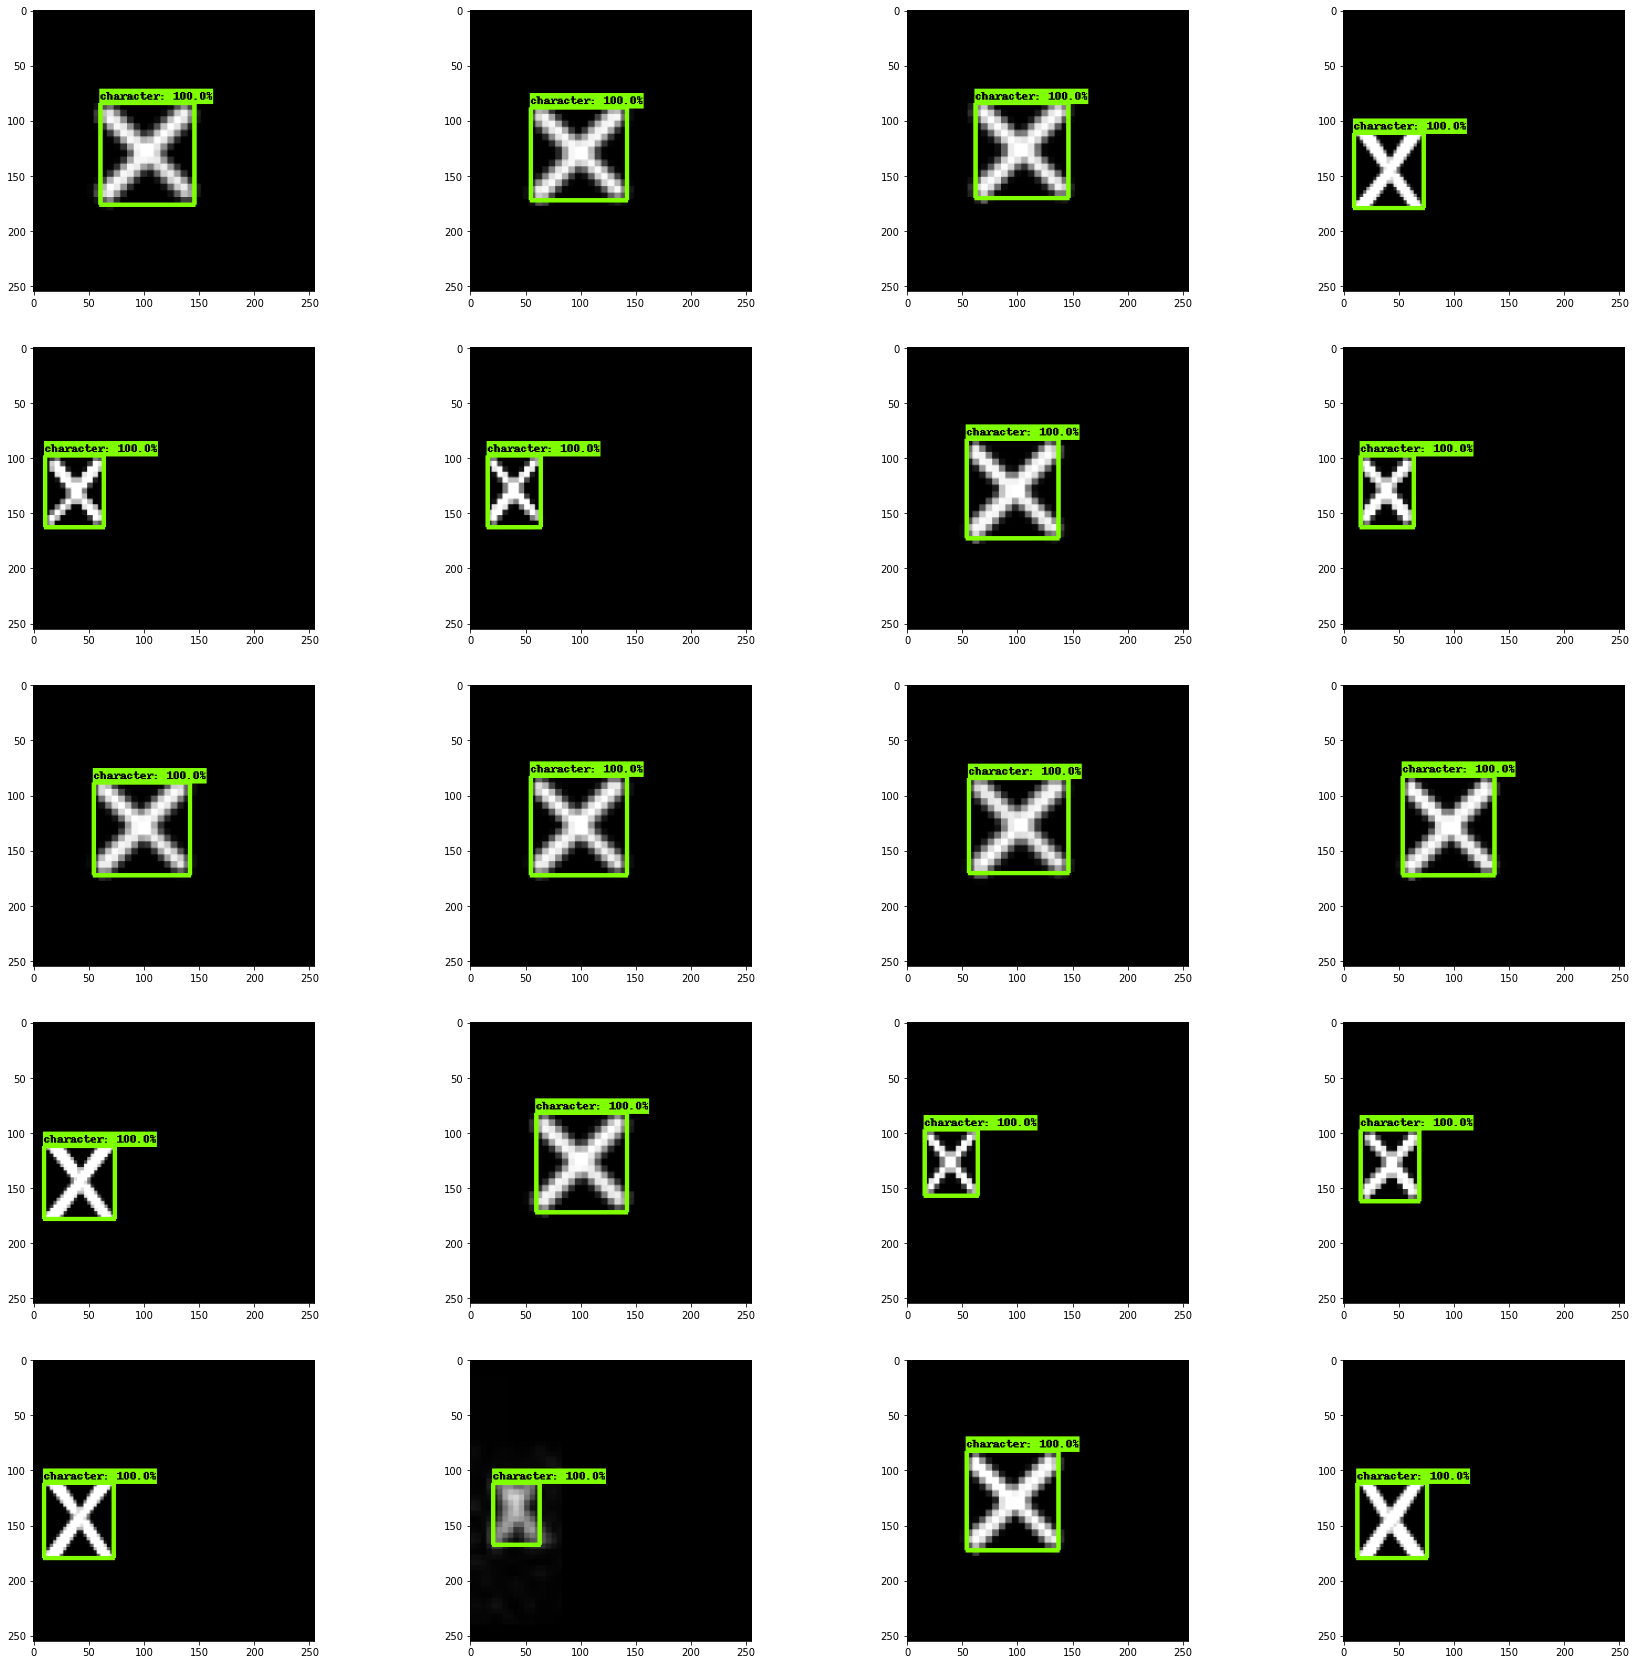

In [17]:
# gt_boxes[] = np.float32
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 30))
for idx in range(len(train_images_np)):
    
    if idx < 20:
    #     plt.subplot(5, 4, idx+1)
        plt.subplot(5, 4, idx+1)

    #     print(gt_boxes[idx] * 255)
        plot_detections(
          train_images_np[idx],
          gt_boxes[idx],
          np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
          dummy_scores, category_index)
                     
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [10]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-09-11 04:01:25--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.196.240
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.196.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  10.4MB/s    in 22s     

2020-09-11 04:01:47 (10.8 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [28]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

detection_model = model_builder.build(model_config=model_config, is_training=True)


# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

Building model and restoring weights for fine-tuning...


In [29]:
# 以下はテストコード
# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


In [13]:
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

# Eager mode custom training loop



In [14]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [15]:
%%time
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.4023311
batch 10 of 100, loss=0.50666547
batch 20 of 100, loss=0.12807384
batch 30 of 100, loss=0.12508526
batch 40 of 100, loss=0.07510243
batch 50 of 100, loss=0.06914759
batch 60 of 100, loss=0.08792389
batch 70 of 100, loss=0.11018134
batch 80 of 100, loss=0.07733437
batch 90 of 100, loss=0.052374087
Done fine-tuning!
CPU times: user 22.9 s, sys: 915 ms, total: 23.8 s
Wall time: 28.9 s


# Load test images and run inference with new model!

In [7]:
# Load images and visualize
import cv2
import glob
test_image_dir = "/home/tensorflow/models/research/object_detection/test_images/cell_image/anotated_image_v6_add_dataset/x/"
#test_image_dir = "/home/tensorflow/models/research/object_detection/test_images/ducky/test/"
filenames = glob.glob(test_image_dir + "*")
  
sort_filename = sorted(filenames)
test_images_np = []
for f in sort_filename:
    img = cv2.imread(f)
    test_images_np.append(img)

In [9]:
# Again, uncomment this decorator if you want to run inference eagerly
# @tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

# 可視化

(1, 255, 255, 3)


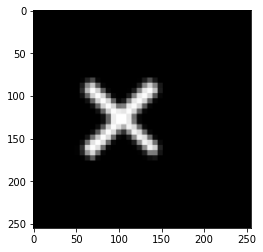

In [18]:
index = 2

#input_tensor = tf.convert_to_tensor(test_images_np[index], dtype=tf.float32)
input_tensor = tf.expand_dims(tf.convert_to_tensor(test_images_np[index], dtype=tf.float32), axis=0)
print(input_tensor.shape)
detections = detect(input_tensor)

label_id_offset = 1

plot_detections(
    test_images_np[index],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + label_id_offset,
    detections['detection_scores'][0].numpy(), category_index)
plt.show()

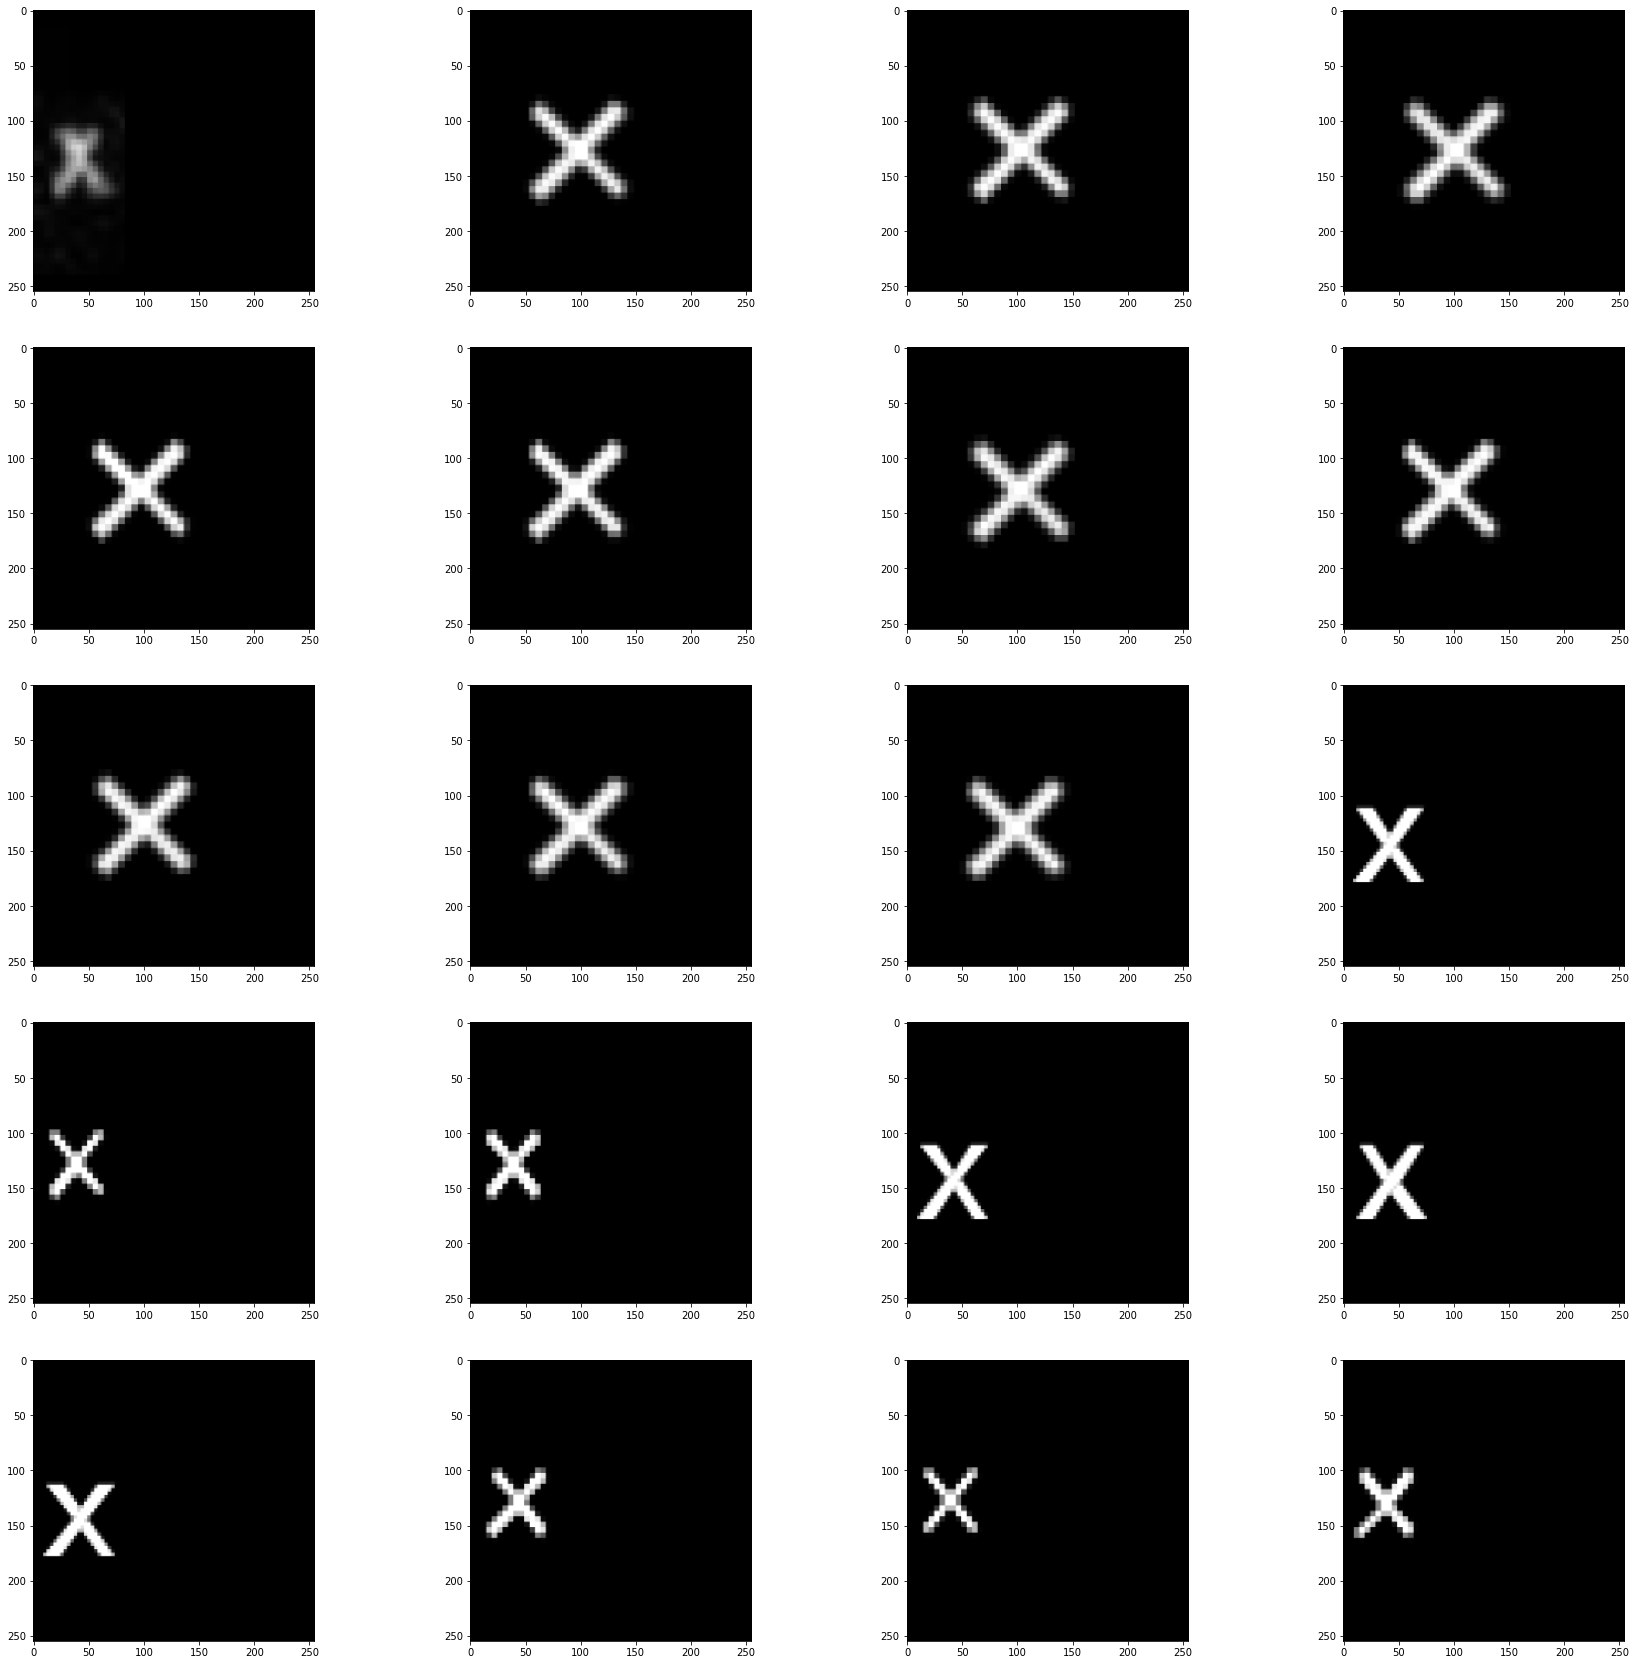

In [15]:
# gt_boxes[] = np.float32
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 30))
for idx in range(len(test_images_np)):
    
    if idx < 20:
        input_tensor = tf.expand_dims(tf.convert_to_tensor(test_images_np[idx], dtype=tf.float32), axis=0)
        detections = detect(input_tensor)

        plt.subplot(5, 4, idx+1)
        plot_detections(
            test_images_np[idx],
            detections['detection_boxes'][0].numpy(),
            detections['detection_classes'][0].numpy().astype(np.uint32)
            + label_id_offset,
            detections['detection_scores'][0].numpy(), category_index)
                     
plt.show()

# plot without using plot_detections()

In [20]:
def plot_bbox(bbox, img):
    # for_duckey
#     y1 = int(bbox[0] * 540)
#     x1 = int(bbox[1] * 960)
#     y2 = int(bbox[2] * 540)
#     x2 = int(bbox[3] * 960)
    
    # for_cell_image
    y1 = int(bbox[0] * 255)
    x1 = int(bbox[1] * 255)
    y2 = int(bbox[2] * 255)
    x2 = int(bbox[3] * 255)
    
    imgrectngle = cv2.rectangle(img, (x1,y1),(x2,y2), (255,0,0), 3)
    plt.imshow(imgrectngle)

1 object detected !!


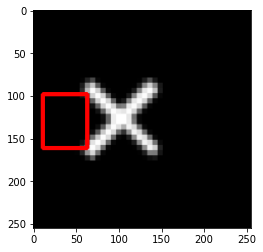

In [26]:
thre = 0.9
object_num, = np.where(detections['detection_scores'][0].numpy() > thre)

print("{} object detected !!".format(len(object_num)))

target_bbox, = detections['detection_boxes'][0].numpy()[object_num]
plot_bbox(target_bbox, test_images_np[index])

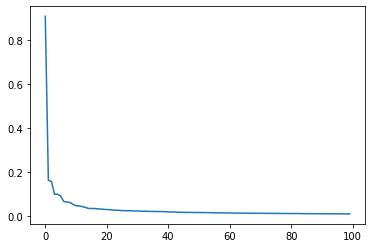

In [22]:
plt.plot(detections['detection_scores'][0].numpy())

## export model

In [23]:
#run conversion script
import re
import numpy as np

output_directory = "/home/tensorflow/models/research/object_detection/colab_tutorials/trained_model"

#place the model weights you would like to export here

last_model_path = '/home/tensorflow/models/research/object_detection/test_data/checkpoint'
pipeline_file = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

print(last_model_path)
!python /home/tensorflow/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/home/tensorflow/models/research/object_detection/test_data/checkpoint
W0911 04:04:05.462560 140048565712704 save_impl.py:78] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7f5f440e3a90>, because it is not built.
INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5e2d372198>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5e2d372208>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5e2d372518>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).
I0911 04:04:24.353133 140048565712704 def_function.py:1038] Unsupported signature for serialization: (([(<tensorflow.python.framework.

## import model

In [4]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config =  'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = "/home/tensorflow/models/research/object_detection/colab_tutorials/trained_model/checkpoint/ckpt-0"

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

detection_model = model_builder.build(model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

Building model and restoring weights for fine-tuning...


In [5]:
# 以下はテストコード
# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!
